[View in Colaboratory](https://colab.research.google.com/github/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_part2_lifter_segmentation.ipynb)

# W207 Final Project: OpenBarbell

## Part 2: Lifter Segmentation

## 9 August 2018

### Project Description

OpenBarbell is a device that measures key lifting metrics during a lifter's workout. Example metrics are weight (user entry), peak velocity, and rep time (device captured). These metrics can be used by a lifter to better understand and improve their performance. The goal of this project is to use the data produced by OpenBarbell to add greater intelligence to the user experience.

### Project Goals

 1. *Exercise classification*. Exercise name is an open field (lifters can enter whatever they want or nothing at all). However, it is one of the key variables to analyze lifter performance. Hence, we would like to build an algorithm to determine exercise for each set based on its characteristics (weight, range of motion, velocity etc.)
 2. *Lifter segmentation*. Can we create distinct groups of lifters based on their lifting characteristics for each exercise (velocity, range of motion, weight)? This would help create semi-customized training programs.

### Data and Source

 - [OpenBarbell Data](https://github.com/squatsandsciencelabs/OpenBarbell-V3/wiki/OpenBarbell-Data-Storage-Format) - the dataset is provided by Squats and Science Barbell, no NDA is required per owner (Jordan Berke)
 - [Project GitHub Repository](https://github.com/YuliaZamriy/W207_Group_Project)

### Team
 - Renzee Reyes
 - Tim Witthoefft
 - Jack Workman
 - Yulia Zamriy

### Part 1: Exercise Classification available here:
https://github.com/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_baseline_submission_v2.ipynb


# Part 2. Lifter Segmentation Overview

TODO
Explain why lifter+exercise


# Notebook Outline

1. Import the Data
2. EDA for Lifter Segmentation
3. Data Preprocessing
4. Data Cleaning
5. Separate Data Into Train & Test Sets
6. Data Visualization
7. Hierarchical Clustering
8. Bringing It All Together
9. Example User

In [0]:
#!git clone https://github.com/YuliaZamriy/W207_Group_Project.git

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!pip install -q keras

In [299]:
## make sure Google Drive is mounted
!ls 

datalab  drive


In [0]:
import warnings
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale
import sys
import itertools
from mpl_toolkits.mplot3d import Axes3D
from locale import atof
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from scipy.cluster.hierarchy import fcluster
from scipy.stats import mode

%matplotlib inline
VERBOSE = True

In [0]:
warnings.filterwarnings(action='once')

In [111]:
# Jupyter viewing options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)

# suppress scientific float notation
np.set_printoptions(precision=5, suppress=True)

# 1. Import The Data

More information on the data and an initial EDA can be observed in our first notebook found here: https://github.com/YuliaZamriy/W207_Group_Project/blob/master/w207_openbarbell_baseline_submission_v2.ipynb


In [0]:
# upload raw dataset
df = pd.read_csv("drive/Colab Notebooks/ob_data_w207_filtered.csv")

In [0]:
## Uncomment this if running locally on Jupyter Notebooks

# csv_data_file = 'ob_data_w207_filtered.csv'
# zip_data_file = 'ob_data_w207_filtered.zip'

# locale.setlocale(locale.LC_NUMERIC, '')

# df = None
# if not os.path.exists(csv_data_file) and os.path.exists(zip_data_file):
#     zip_ref = zipfile.ZipFile(zip_data_file, 'r')
#     zip_ref.extractall()
#     zip_ref.close()
# if os.path.exists(csv_data_file):
#     df = pd.read_csv(csv_data_file)
#     # -- pandas supposedly coverts '7,39' to '7.39' with decimal arg but it didn't work
#     #df = pd.read_csv(csv_data_file, decimal='.')
# else:
#     raise Exception('Data file not found! {0}'.format(csv_data_file))

# 2. EDA for Lifter Segmentation

### Potential features to consider for lifter segmentation:

 Lifting-related:
 
 - `rpe_num`: uses RPE or not
 - `weight_lbs`
 - `RepCount`: values start from 0 (counts of 1); higher repper vs. low
 - `ROM`
 - `AvgVel`
 - `PeakVel`
 - `PeakVelLoc`
 - `RepDur`
 - `PeakAccel`


User-related (will be considered in future analysis):

 - `initialStartTime` / `startTime` / `time`
 - `tags`: tagger or not
 - `workoutID`: number of unique workouts
 - `hardware`:  two values: (ios, android)
 - `deviceName`/`deviceIdentifier`:  how many devices is using
 
 
 ### Potential lifter identifiers:
 
 - Primary: `userID`
 - Secondary: `exercise_clean`


### 2.1 Unique User IDs

The segmentation will be performed on lifter level, which is best represented by `userID` (unique ID for each application instance). It is technically possible for multiple users to use the same app, but there is no way right now to determine that.

#### How many unique user IDs in the dataset?

In [0]:
def feature_descr(feature, ends=5):
  
  """
  Prints out descriptive information for an input feature:
    - descriptive statistics
    - number of lowest occuring values
    - number of highest occuring values
    - historgram
    
  Args:
    feature: series or array
  
  Kwargs:
    ends: int, number of lowest/highest values to analyze
  """
    
  print(f"{feature.name} Summary:")
  print(feature.describe())
  
  low = userID_count.sort_values(ascending=True).unique()[:ends]
  high = userID_count.sort_values(ascending=False).unique()[:ends]
  
  print(f"\nLow occurrence for {feature.name}:")
  for i in low:
    print(f"There are {sum(feature==i)} unique values with {i} observation(s)")
  
  print(f"\nHigh occurrence for {feature.name}:")
  for i in high:
    print(f"There are {sum(feature==i)} unique values with {i} observation(s)")
 
  xmin, xmax = np.min(feature), np.nanpercentile(feature, 99)
  plt.hist(feature, 100, facecolor = 'g', alpha = 0.75)
  plt.xlim([xmin, xmax])
  plt.title(f"Histogram for {feature.name}", fontsize=20)
  plt.show()

In [9]:
userID_count = df['userID'].value_counts()
userID_count.name = 'userID_count'
print(userID_count.shape)

(460,)


userID_count Summary:
count      460.000000
mean       636.760870
std       1257.673288
min          1.000000
25%         27.750000
50%        111.500000
75%        571.250000
max      10568.000000
Name: userID_count, dtype: float64

Low occurrence for userID_count:
There are 2 unique values with 1 observation(s)
There are 4 unique values with 2 observation(s)
There are 8 unique values with 3 observation(s)
There are 6 unique values with 4 observation(s)
There are 6 unique values with 5 observation(s)

High occurrence for userID_count:
There are 1 unique values with 10568 observation(s)
There are 1 unique values with 7315 observation(s)
There are 1 unique values with 5944 observation(s)
There are 1 unique values with 5824 observation(s)
There are 1 unique values with 5812 observation(s)


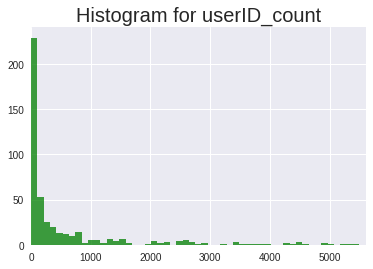

In [300]:
feature_descr(userID_count)

In [0]:
def check_frequency(feature, top=10):
    """
    Displays frequency of unique values.
    If there are more than ten unique values, displays only top 10

    Args:
      feature: array

    Kwargs:
      top: int, number of unique values to display
    """  
  
    counts = feature.value_counts()
    print(f"\n{feature.name} has {counts.shape[0]} unique values")
    print("Top 10 values are:")
    if counts.shape[0] > 10:
          print(counts[:10])
    else:
          print(counts)

In [85]:
# get number of reps for each exercise
check_frequency(df['exercise_clean'])


exercise_clean has 6 unique values
Top 10 values are:
bench             94640
squat             77680
squat other       42141
deadlift          35966
bench other       35117
deadlift other     7366
Name: exercise_clean, dtype: int64


In [0]:
# Getting the counts for user+exercise grouping
# Selecting only 3 clean exercises since they are the main lifts of interest
df_temp = df.loc[df['exercise_clean'].isin(["squat", "bench", "deadlift"])]
df_grouped_exercise = df_temp.groupby(['userID', 'exercise_clean'])
df_grouped_exercise = df_grouped_exercise.size()
df_grouped_exercise.name = 'userID-exercise_count'

In [39]:
# Checking how many users have data with multiple exercises
df_grouped_exercise2 = df_grouped_exercise.groupby('userID')
df_grouped_exercise2 = df_grouped_exercise2.size()
check_frequency(df_grouped_exercise2)


userID-exercise_count has 3 unique values
Top 10 values are:
3    183
1    142
2     95
Name: userID-exercise_count, dtype: int64


### 2.2 Feature EDA 

In [0]:
ls_cont_features = ['rpe_num', 'RepCount', 'weight_lbs', 'AvgVel',
                   'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'PeakAccel']

In [13]:
def get_descr(data, features=None):
    if features is None:
        features = data.columns
    data_descr = data[features].describe()
    pct_missing = pd.Series(100-np.around(data_descr.loc['count',]/data.shape[0]*100,2))
    pct_missing.name = 'pct_missing'
    pct_zero = pd.Series([100*sum(data[v] == 0)/data.shape[0] for v in features])
    pct_zero.name = 'pct_zeros'
    pct_zero.index = pct_missing.index
    data_descr = data_descr.append(pct_missing)
    data_descr = data_descr.append(pct_zero)
    return data_descr
  
get_descr(df, ls_cont_features)

,rpe_num,RepCount,weight_lbs,AvgVel,ROM,PeakVel,PeakVelLoc,RepDur,PeakAccel
count,107928.000000,292910.000000,283142.000000,292891.000000,292910.000000,292910.000000,288513.000000,2.885130e+05,204717.000000
mean,7.330340,2.775013,235.271909,0.479184,462.061456,0.771857,72.132299,1.102977e+06,15.439559
std,1.201296,4.143754,105.251502,0.223486,157.312786,0.377337,20.038203,4.745798e+05,59.320897
min,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,6.500000,1.000000,165.000000,0.320720,326.000000,0.483974,65.000000,7.656250e+05,3.307050
50%,7.000000,2.000000,225.000000,0.435733,450.000000,0.718287,79.000000,1.030670e+06,6.186958
75%,8.000000,4.000000,300.000000,0.591369,598.000000,0.976293,87.000000,1.363892e+06,12.775880
max,10.000000,114.000000,1000.000000,2.960175,1761.000000,5.560000,99.000000,1.129953e+07,2686.953000
pct_missing,63.150000,0.000000,3.330000,0.010000,0.000000,0.000000,1.500000,1.500000e+00,30.110000
pct_zeros,0.000000,22.791984,0.130415,0.001366,0.001366,0.001366,0.013997,6.145232e-03,0.017411


### 2.3 Workouts per User Analysis

In [0]:
# Getting user level unique workout counts
df_grouped_wourkout = df.groupby(['userID', 'workoutID'])
df_grouped_wourkout = df_grouped_wourkout.size()
df_grouped_wourkout.name = 'userID-workoutID_count'

In [61]:
# checking how many workouts per user are most frequently in the database
check_frequency(df_grouped_wourkout)


userID-workoutID_count has 137 unique values
Top 10 values are:
3     430
15    406
20    359
9     323
2     314
12    307
18    307
4     302
6     302
24    298
Name: userID-workoutID_count, dtype: int64


In [62]:
# checking the user with the max amount reps per user+workout
df_grouped_wourkout.loc[df_grouped_wourkout == max(df_grouped_wourkout)]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
Name: userID-workoutID_count, dtype: int64

In [63]:
# this is account used for S&S internal study
# we might need to exclude it (because it's for multiple people)
df_study = df.loc[df['userID'] == '5aa35456880e87b3f32ddf7c']
df_study.shape

(3506, 45)

In [64]:
# checking the top occuring values for user+workout
# values are number of reps per user+workout
df_grouped_wourkout.sort_values(ascending=False)[:10]

userID                    workoutID                           
5aa35456880e87b3f32ddf7c  c1d046a3-bf4e-4ba8-a43a-2568a3b21620    345
                          7464e24b-25af-4435-a29e-6735cf838dd4    305
                          870ca10a-1f71-4cbf-a3f8-6ef0f0cc56c1    281
                          21b51e5a-6a80-48d8-827b-b2309f4cd405    201
5a43c264fd4ef00da9b8ccce  3388ac48-1f31-46c1-88db-d82b72209a01    184
5a15b00e05cbc9b8ef26ac59  4d2ad298-337d-46bb-bd46-49f45d42158e    183
59debbdd05cbc9b8ef26ac1c  dbc82f2e-0401-43c6-9c9a-afc52434f724    176
5aa35456880e87b3f32ddf7c  908fe3e3-34c9-4c2f-8ae4-7d22354e2b9b    175
589d473d6ca711fcd8cb7af9  93a67da5-12c4-42d1-a067-ca77e04af8ab    174
5a43c264fd4ef00da9b8ccce  426232d3-7874-4c44-9a5a-6e9b860bbf1c    151
Name: userID-workoutID_count, dtype: int64

### 2.4 EDA Conclusions

TODO

# 3. Data Preprocessing

Each row in the initial dataset corresponds to one rep performed by a user. Lifters usually perform various number of reps in a set and multiple sets in a workout.

In this section, we attempt to summarize the characterization of each user's squat, bench, or deadlift by grouping and aggregating certain features.

In [0]:
def data_preprocessing(data):
    data = data.assign(RepCount = df['RepCount'] + 1)
    return data
  
def select_exercise(data, exercise, exercise_col='exercise_clean', verbose=False):
    exercise_only = data.loc[data['exercise_clean'].isin([exercise])]
#     exercise_only = exercise_only.drop('exercise_clean', axis=1)
    
    if verbose:
        print('Selected Exercise "{0}": shape_before={1}, shape_after={2}'
              .format(exercise, data.shape, exercise_only.shape))
        
    return exercise_only
  
def group_data(data, group_cols, feature_cols, verbose=False):
    data = data[group_cols + feature_cols].groupby(group_cols)

    return data
  
def aggregate_data(data, aggregator_funcs, verbose=False):
    data_aggd = data.agg(aggregator_funcs)
    data_aggd.columns = data_aggd.columns.map('_'.join)
    features = list(data_aggd.columns)
    if verbose:
        print('Aggregated Data: shape={0}'.format(data_aggd.shape))
        print('Features={0}'.format(features))
        
    return data_aggd, features
  
def group_and_aggregate_data(data, group_cols, feature_cols, aggregator_funcs, verbose=False):
    grouped = group_data(data, group_cols, feature_cols, verbose)
    aggregated, features = aggregate_data(grouped, aggregator_funcs, verbose)
    
    grp_and_aggd = aggregated.reset_index()
    
    # we do not need groupby columns anymore
#     grp_and_aggd = grp_and_aggd.drop(group_cols, axis=1)
    
    if verbose:
        print('Grouped and Aggregated Data: shape={0}'.format(grp_and_aggd.shape))

    return grp_and_aggd, features   

In [15]:
df_proc = data_preprocessing(df)

# exercise = 'bench'
df_bench = select_exercise(df_proc, 'bench', verbose=VERBOSE)
df_squat = select_exercise(df_proc, 'squat', verbose=VERBOSE)
df_deadlift = select_exercise(df_proc, 'deadlift', verbose=VERBOSE)

Selected Exercise "bench": shape_before=(292910, 45), shape_after=(94640, 45)
Selected Exercise "squat": shape_before=(292910, 45), shape_after=(77680, 45)
Selected Exercise "deadlift": shape_before=(292910, 45), shape_after=(35966, 45)


In [16]:
feature_cols = ['weight_lbs', 'RepDur', 'AvgVel', 'ROM']
group_cols = ['userID', 'exercise_clean']
aggregator_funcs = [np.mean]

df_bench_grouped, final_features = group_and_aggregate_data(df_bench, group_cols, feature_cols, aggregator_funcs, verbose=VERBOSE)
df_squat_grouped, _ = group_and_aggregate_data(df_squat, group_cols, feature_cols, aggregator_funcs, verbose=VERBOSE)
df_deadlift_grouped, _ = group_and_aggregate_data(df_deadlift, group_cols, feature_cols, aggregator_funcs, verbose=VERBOSE)

Aggregated Data: shape=(323, 4)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean']
Grouped and Aggregated Data: shape=(323, 6)
Aggregated Data: shape=(311, 4)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean']
Grouped and Aggregated Data: shape=(311, 6)
Aggregated Data: shape=(247, 4)
Features=['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean']
Grouped and Aggregated Data: shape=(247, 6)


In [167]:
df_deadlift_grouped.head()

,userID,exercise_clean,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean
0,589bcb116ca711fcd8cb7af3,deadlift,92.098539,1.736786e+06,0.315348,513.501629
1,589c69d26ca711fcd8cb7af4,deadlift,242.508200,1.456683e+06,0.391967,459.466667
2,589cef4a6ca711fcd8cb7af6,deadlift,295.288462,9.540745e+05,0.605430,517.634615
3,589d473d6ca711fcd8cb7af9,deadlift,302.163006,1.528695e+06,0.281831,406.478859
4,589d66f46ca711fcd8cb7afa,deadlift,446.171473,1.980603e+06,0.183052,352.842266


In [168]:
get_descr(df_deadlift_grouped, list(df_grouped)[2:])

,weight_lbs_mean,RepDur_mean,AvgVel_mean,ROM_mean
count,241.000000,2.440000e+02,247.000000,247.000000
mean,322.180102,1.247090e+06,0.499450,499.029429
std,110.175352,4.075544e+05,0.281082,92.555539
min,2.666667,2.252466e+05,0.168204,194.666667
25%,245.413513,9.766092e+05,0.336801,449.766646
50%,315.000000,1.211856e+06,0.440215,504.720000
75%,391.818182,1.486355e+06,0.578724,549.916865
max,892.871100,2.609518e+06,2.619066,1146.444444
pct_missing,2.430000,1.210000e+00,0.000000,0.000000
pct_zeros,0.000000,0.000000e+00,0.000000,0.000000


# 4. Data Cleaning

Two issues arise with this dataset that must be resolved before clustering. The first is missing data which we handle with sklearn's Imputer. The second is standardizing feature values. This we accomplish with sklearn's StandardScaler class.

## 4.1 Handle Missing Data

In [0]:
def impute_data(data, verbose=False):
    """
    Imputes missing values with medians to avoid skews by outliers
    
    Args:
        data: feature dataset used to fit and apply impute calculations
        verbose: bool, specifies whether to print out the checks
    
    Returns:
        input dataset with imputed means
    """
    
    ids =  data[group_cols]       
    data = data.drop(group_cols, axis = 1)
    
    data_im = preprocessing.Imputer(strategy='median').fit_transform(data)
    data_im = pd.DataFrame(data_im, index=data.index, columns=data.columns)
    
    if verbose:
        print(f"\nFeature means before impute:\n {round(data.mean(),2)}")
        print(f"\nNumber of missing values: {data.isnull().sum().sum()}")
        print(f"\nFeature means after impute:\n {round(data_im.mean(),2)}")
        print(f"\nNumber of missing after impute:\n {np.isnan(data_im).sum()}")
    
    data_im = data_im.join(ids)

    return data_im

In [18]:
print("\nProcessing for bench:")
df_bench_imputed = impute_data(df_bench_grouped, verbose=VERBOSE)
print("\nProcessing for squat:")
df_squat_imputed = impute_data(df_squat_grouped, verbose=VERBOSE)
print("\nProcessing for deadlift:")
df_deadlift_imputed = impute_data(df_deadlift_grouped, verbose=VERBOSE)


Processing for bench:

Feature means before impute:
 weight_lbs_mean       201.73
RepDur_mean        925525.93
AvgVel_mean             0.46
ROM_mean              343.09
dtype: float64

Number of missing values: 12

Feature means after impute:
 weight_lbs_mean       201.54
RepDur_mean        925443.57
AvgVel_mean             0.46
ROM_mean              343.09
dtype: float64

Number of missing after impute:
 weight_lbs_mean    0
RepDur_mean        0
AvgVel_mean        0
ROM_mean           0
dtype: int64

Processing for squat:

Feature means before impute:
 weight_lbs_mean        277.98
RepDur_mean        1179591.54
AvgVel_mean              0.60
ROM_mean               610.40
dtype: float64

Number of missing values: 16

Feature means after impute:
 weight_lbs_mean        277.54
RepDur_mean        1179478.17
AvgVel_mean              0.60
ROM_mean               610.40
dtype: float64

Number of missing after impute:
 weight_lbs_mean    0
RepDur_mean        0
AvgVel_mean        0
ROM_mean    

## 4.2 Standardize Features

In [0]:
def standardize_data(data, verbose=False):
    """
    Standardizes input dataset 
    
    Args:
        data: feature dataset used to fit and apply standardization
        verbose: bool, specifies whether to print out the checks
    
    Returns:
        tuple, standardized dataset, fitted scaler
    """
    
    ids =  data[group_cols]       
    data = data.drop(group_cols, axis = 1)
    
    scaler = preprocessing.StandardScaler().fit(data)
    scaled_data = scaler.transform(data)
    #scaled_data = preprocessing.RobustScaler().fit_transform(data)
    data_std = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)
 
    if verbose:
        print(f"\nMeans of standardized features:\n {np.around(np.mean(data_std, axis = 0),2)}")
        print(f"\nStd dev of standardized features:\n {np.around(np.std(data_std, axis = 0),2)}")
        
    data_std = data_std.join(ids)
    
    
    return data_std, scaler

In [20]:
print("\nProcessing for bench:")
df_bench_clean, scaler_bench = standardize_data(df_bench_imputed, verbose=VERBOSE)
print("\nProcessing for squat:")
df_squat_clean, scaler_deadlift = standardize_data(df_squat_imputed, verbose=VERBOSE)
print("\nProcessing for deadlift:")
df_deadlift_clean, scaler_deadlift = standardize_data(df_deadlift_imputed, verbose=VERBOSE)


Processing for bench:

Means of standardized features:
 weight_lbs_mean   -0.0
RepDur_mean       -0.0
AvgVel_mean       -0.0
ROM_mean          -0.0
dtype: float64

Std dev of standardized features:
 weight_lbs_mean    1.0
RepDur_mean        1.0
AvgVel_mean        1.0
ROM_mean           1.0
dtype: float64

Processing for squat:

Means of standardized features:
 weight_lbs_mean    0.0
RepDur_mean        0.0
AvgVel_mean        0.0
ROM_mean           0.0
dtype: float64

Std dev of standardized features:
 weight_lbs_mean    1.0
RepDur_mean        1.0
AvgVel_mean        1.0
ROM_mean           1.0
dtype: float64

Processing for deadlift:

Means of standardized features:
 weight_lbs_mean   -0.0
RepDur_mean        0.0
AvgVel_mean       -0.0
ROM_mean           0.0
dtype: float64

Std dev of standardized features:
 weight_lbs_mean    1.0
RepDur_mean        1.0
AvgVel_mean        1.0
ROM_mean           1.0
dtype: float64


# 5. Separate Data Into Train & Test Sets

In [265]:
df_bench_train, df_bench_test = train_test_split(df_bench_clean,
                                                 test_size=0.1,
                                                 shuffle=True,
                                                 random_state=5)

print(df_bench_train.shape)
print(df_bench_test.shape)

(290, 6)
(33, 6)


In [22]:
df_squat_train, df_squat_test = train_test_split(df_squat_clean,
                                                 test_size=0.1,
                                                 shuffle=True,
                                                 random_state=5)

print(df_squat_train.shape)
print(df_squat_test.shape)

(279, 6)
(32, 6)


In [23]:
df_deadlift_train, df_deadlift_test = train_test_split(df_deadlift_clean,
                                                       test_size=0.1,
                                                       shuffle=True,
                                                       random_state=5)

print(df_deadlift_train.shape)
print(df_deadlift_test.shape)

(222, 6)
(25, 6)


In [24]:
df_train = pd.concat([df_bench_train, df_squat_train, df_deadlift_train], axis=0)
df_train.shape

(791, 6)

In [25]:
check_frequency(df_train['exercise_clean'])


exercise_clean has 3 unique values
Top 10 values are:
bench       290
squat       279
deadlift    222
Name: exercise_clean, dtype: int64


# 6. Feature Visualization



In [0]:
# https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
cmaps = ['YlGn', 'RdPu', 'OrRd', 'Purples', 'YlGnBu', 'Reds']

def plot_exercise_grid(data, features_to_include, category='exercise_clean'):
    
    grid = sns.PairGrid(data, 
                        hue = category, 
                        vars = features_to_include, 
                        size = 4,
                        palette = 'hls',
                        hue_kws={"cmap":cmaps})
    # Map a scatter plot to the upper triangle
    grid = grid.map_upper(plt.scatter, alpha=0.5)
    # Map a histogram to the diagonal
    grid = grid.map_diag(sns.kdeplot, shade=True)
    # Map a density plot to the lower triangle
    # This gives a lot of innocuous warnings if warnings are not disabled
    grid = grid.map_lower(sns.kdeplot, shade=True, shade_lowest=False)    
    grid = grid.add_legend()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


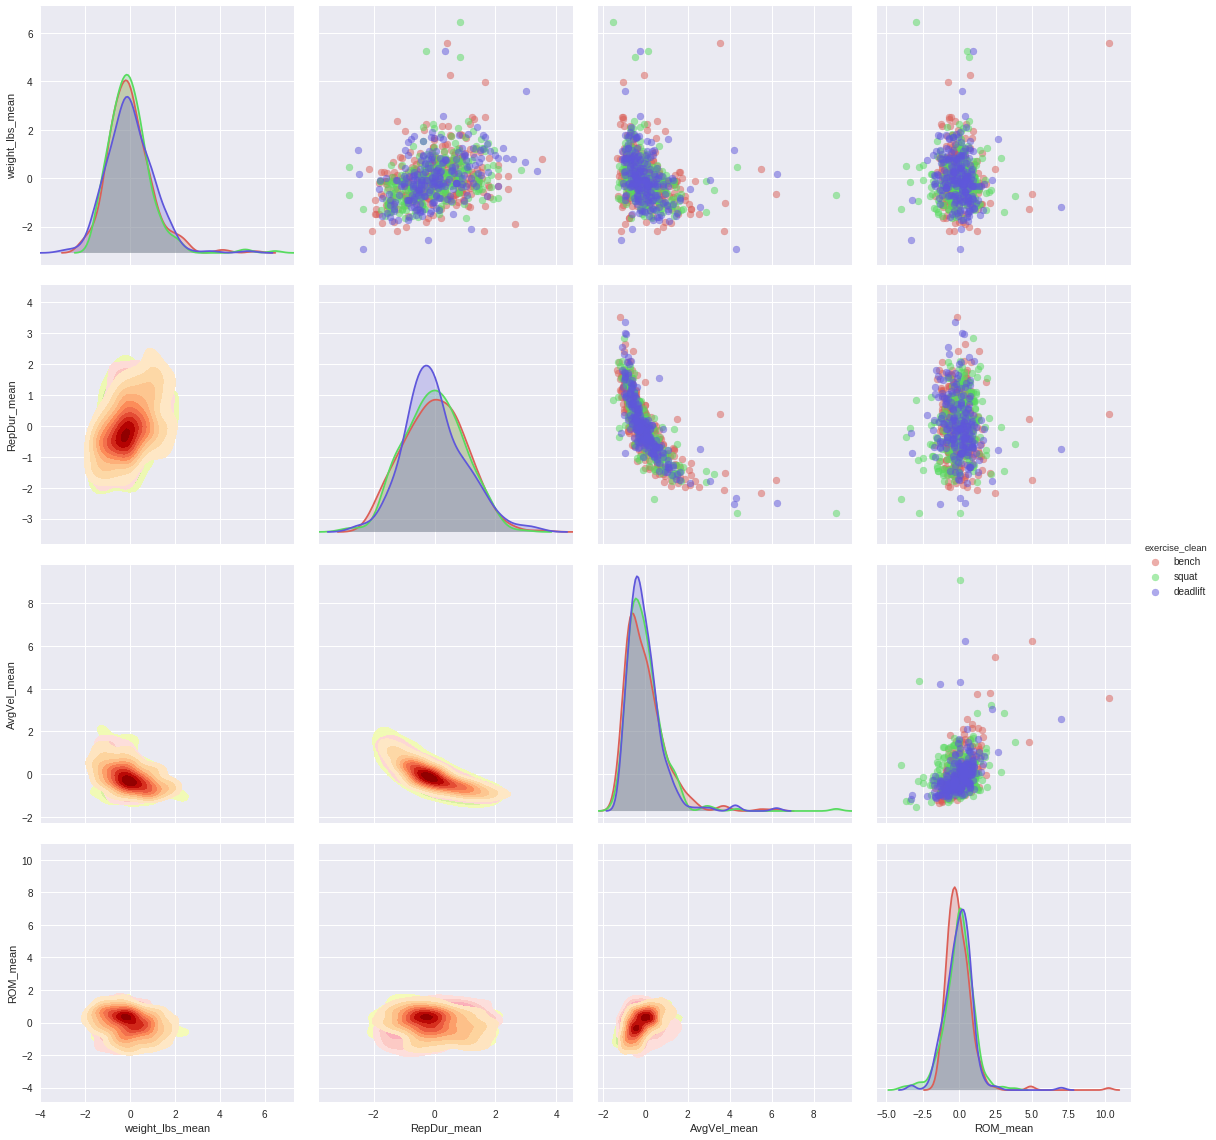

In [159]:
plot_exercise_grid(df_train, final_features)

In [62]:
def stack_pca_data(data, n_pca):
    
    ids =  data[group_cols]      
    
    data_out = np.empty(shape=(0,n_pca))
    for ex in ['bench', 'squat', 'deadlift']:
        pca_data = data[data['exercise_clean']==ex].drop(group_cols, axis=1)
        pca_data = PCA(n_components=n_pca).fit_transform(pca_data)
        print(f"{ex} data shape: {pca_data.shape}")
        data_out = np.concatenate((data_out, pca_data), axis = 0)
    print(f"Final dataset shape: {data_out.shape}")
    
    data_out = pd.DataFrame(data_out)
    data_out = data_out.join(ids)
        
    return data_out

df_train_pca2 = stack_pca_data(df_train, 2)
df_train_pca3 = stack_pca_data(df_train, 3)

bench data shape: (290, 2)
squat data shape: (279, 2)
deadlift data shape: (222, 2)
Final dataset shape: (791, 2)
bench data shape: (290, 3)
squat data shape: (279, 3)
deadlift data shape: (222, 3)
Final dataset shape: (791, 3)


In [65]:
df_train_pca3.head()

,0,1,2,userID,exercise_clean
0,0.004208,-0.788137,-0.868803,589bcb116ca711fcd8cb7af3,bench
0,0.004208,-0.788137,-0.868803,589bcb116ca711fcd8cb7af3,squat
0,0.004208,-0.788137,-0.868803,589bcb116ca711fcd8cb7af3,deadlift
1,-0.576490,0.800420,-0.939617,589c69d26ca711fcd8cb7af4,bench
1,-0.576490,0.800420,-0.939617,589c69d26ca711fcd8cb7af4,squat


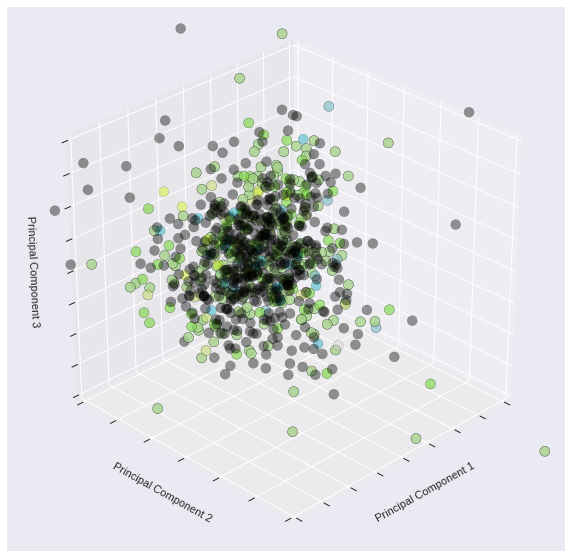

In [191]:
def make_3pca_plot(pca_data):
    """Plots PCA transformed data for two types of mushrooms
    
    Args:
        data: input dataset
        labs: array of class labels (values = (0,1))
        n_comp: int, number of principal components to keep
    """
    
    exercises, labels = pca_data['exercise_clean'].factorize()
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[0], pca_data[1], pca_data[2], 
               cmap=plt.cm.nipy_spectral,
               c = exercises, edgecolor='k',
               alpha = 0.4, s=100)
    
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.set_xlim(-4,4)
    ax.set_ylim(-2,4)
    ax.set_zlim(-2,2)
    ax.view_init(azim=45)
    
    plt.show()
    
make_3pca_plot(df_train_pca3)

# 7. Hierarchical Clustering

All credit goes to:
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

## 7.1 Functional Setup

In [0]:
def plot_dendogram(Z, max_d):
    plt.figure(figsize=(15, 10))
    plt.title('Hierarchical Clustering Dendrogram', fontsize=20)
    plt.xlabel('Number of members')
    plt.ylabel('distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=25,  # show only the last p merged clusters
        leaf_rotation=10.,  # rotates the x axis labels
        leaf_font_size=12.,  # font size for the x axis labels
        color_threshold = max_d
    )
    plt.axhline(y=max_d, c='k', ls='--')
    plt.show()
    
def make_clusters(data, cutoff, link='ward', dist='euclidean', verbose=False):
  
    IDS = data[group_cols]
    # resetting the index to ensure proper merge with clusters
    IDS.reset_index(drop=True, inplace=True)
    
    X = data.drop(group_cols, axis=1).values 
    Z = linkage(X, link)
    max_d = cutoff*max(Z[:,2])
    
    clusters = pd.DataFrame(fcluster(Z, max_d, criterion='distance'), columns=["Cluster"])
    clusters = pd.concat([IDS, clusters], axis=1)
#     clusters = fcluster(Z, max_d, criterion='distance')
    
    if verbose:
      print(f'Maximum distance: {max(Z[:,2]):.2f}')
      print(f'Cut off distance: {max_d:.2f}')
      check_frequency(clusters["Cluster"])

    return Z, max_d, clusters
  
def visualize_clusters_2d(X, Y, colors, title):
    plt.scatter(X, Y, c=colors, cmap='prism', alpha = 0.4, s=100)
    plt.title(title)
    plt.show()

def visualize_clusters_3d(X, Y, Z, colors, title):
    # http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html
    fig = plt.figure(1, figsize=(8, 6))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    ax.set_facecolor('None')
    ax.scatter(X, Y, Z, c=colors, cmap=plt.cm.nipy_spectral,
           edgecolor='k', alpha = 0.4, s=100)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
#     ax.set_xlim(-4,4)
#     ax.set_ylim(-4,6)
#     ax.set_zlim(-4,1)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_zlabel("Principal Component 3")
    ax.view_init(azim=45)

    plt.title(title)
    plt.show()
    
def visualize_clusters(data, features, clusters, title=""):
    
    data = data.drop(group_cols, axis=1)
    print(list(data))
  
    if len(features) == 2:
        visualize_clusters_2d(data[features[0]], data[features[1]], clusters.ravel(), title=title)
    elif len(features) == 3:
        visualize_clusters_3d(data[features[0]], data[features[1]], data[features[2]], clusters.ravel(), title=title)
    elif len(features) > 3:
        print('Dimensions > 3. Running PCA with n=3.')
        pca = PCA(n_components=3)
        pca.fit(data)
        pca_train = pd.DataFrame(pca.transform(data))
        visualize_clusters_3d(pca_train[0], pca_train[1], pca_train[2], clusters.ravel(), title=title)
        
    return

def plot_outliers(data, exercise, ids, features):
    
    data = data[data['exercise_clean']==exercise]
    
    plt.figure(figsize=(10, 8))
    
    plt.scatter(data[features[0]], data[features[1]], 
                c=data['Cluster'], cmap=plt.cm.nipy_spectral,
                edgecolor='k', alpha = 0.4, s=100,
               facecolor='None')
    for user in ids:
        plt.scatter(data[data['userID']==user][features[0]], 
                    data[data['userID']==user][features[1]], 
                    c='r', facecolor='None')  # plot interesting points in red again   
    plt.xlabel(f"{features[0]}")
    plt.ylabel(f"{features[1]}")
    plt.show()

## 7.2 Bench Press Clustering

Maximum distance: 24.68
Cut off distance: 14.81

Cluster has 4 unique values
Top 10 values are:
4    126
1    104
3     57
2      3
Name: Cluster, dtype: int64

Cluster has 4 unique values
Top 10 values are:
4    126
1    104
3     57
2      3
Name: Cluster, dtype: int64


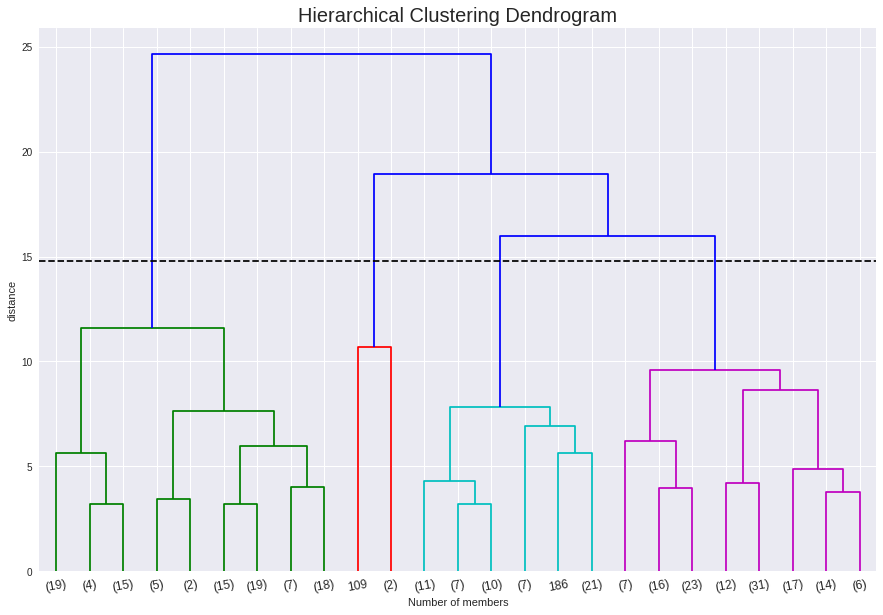

['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean']
Dimensions > 3. Running PCA with n=3.


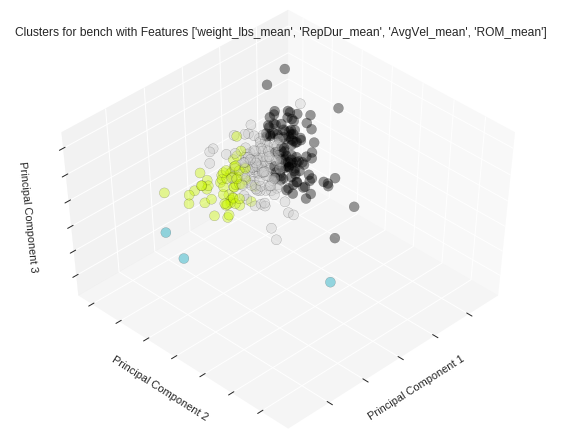

In [371]:
Z, max_d, clusters = make_clusters(df_bench_train, 0.6, verbose=VERBOSE)
# we probably should first do k-means on train and then validate on test
# _, _, clusters_test = make_clusters(df_bench_test, 0.6)  # for use in section Example User below
df_bench_cluster = df_bench_train.set_index(['userID', 'exercise_clean']).join(clusters.set_index(['userID', 'exercise_clean']))
df_bench_cluster.reset_index(inplace=True)
# validate that clusters match make_cluster output
check_frequency(df_bench_cluster["Cluster"])
plot_dendogram(Z, max_d)
visualize_clusters(df_bench_train, final_features, clusters['Cluster'], title='Clusters for {0} with Features {1}'.format('bench', final_features))

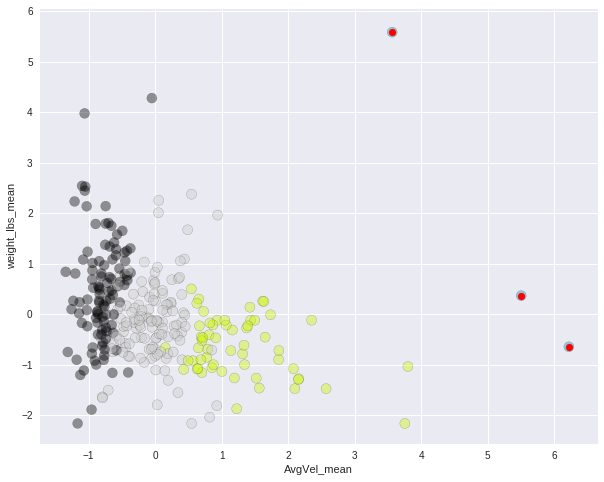

In [372]:
ids = list(clusters[clusters["Cluster"]==2]['userID'])
plot_outliers(df_bench_cluster, 'bench', ids, ['AvgVel_mean', 'weight_lbs_mean'])

## 7.3 Squat Clustering

Maximum distance: 24.03
Cut off distance: 14.42

Cluster has 3 unique values
Top 10 values are:
1    144
3     94
2     41
Name: Cluster, dtype: int64

Cluster has 3 unique values
Top 10 values are:
1    144
3     94
2     41
Name: Cluster, dtype: int64


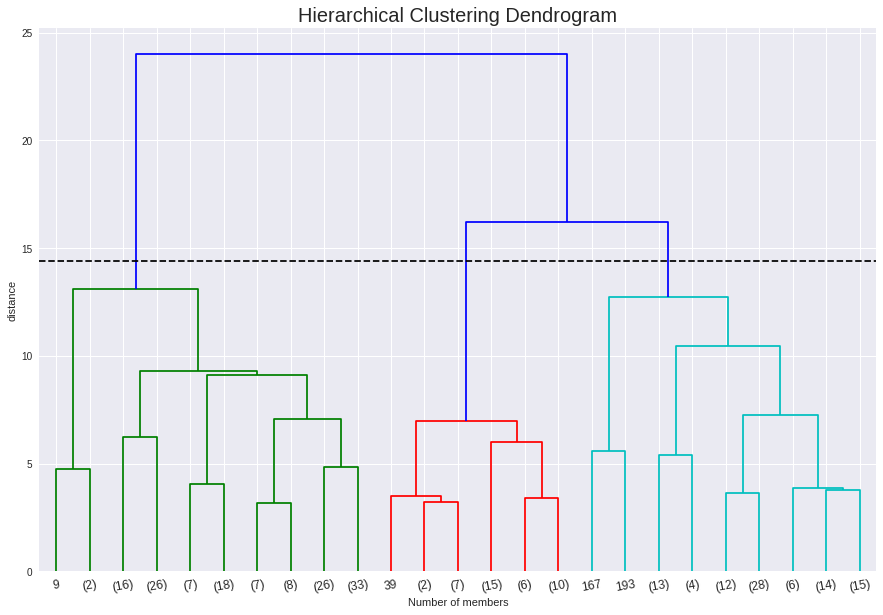

['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean']
Dimensions > 3. Running PCA with n=3.


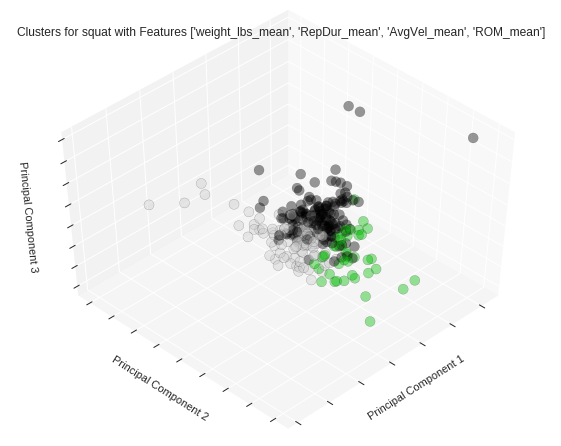

In [332]:
Z, max_d, clusters = make_clusters(df_squat_train, 0.6, verbose=VERBOSE)
df_squat_cluster = df_squat_train.set_index(['userID', 'exercise_clean']).join(clusters.set_index(['userID', 'exercise_clean']))
df_squat_cluster.reset_index(inplace=True)
# validate that clusters match make_cluster output
check_frequency(df_squat_cluster["Cluster"])
plot_dendogram(Z, max_d)
visualize_clusters(df_squat_train, final_features, clusters['Cluster'], title='Clusters for {0} with Features {1}'.format('squat', final_features))

## 7.4 Deadlift Clustering

Maximum distance: 23.24
Cut off distance: 11.62

Cluster has 3 unique values
Top 10 values are:
3    107
1     81
2     34
Name: Cluster, dtype: int64

Cluster has 3 unique values
Top 10 values are:
3    107
1     81
2     34
Name: Cluster, dtype: int64


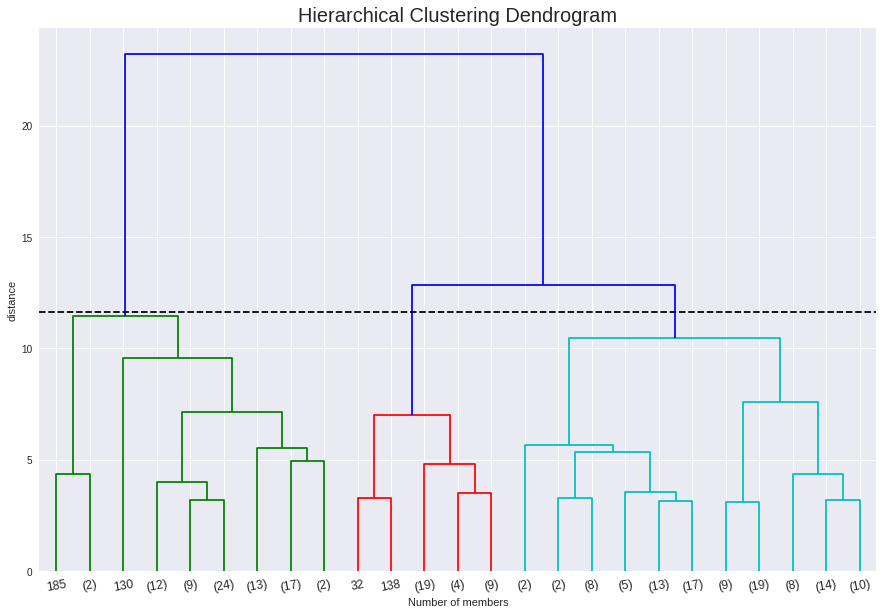

['weight_lbs_mean', 'RepDur_mean', 'AvgVel_mean', 'ROM_mean']
Dimensions > 3. Running PCA with n=3.


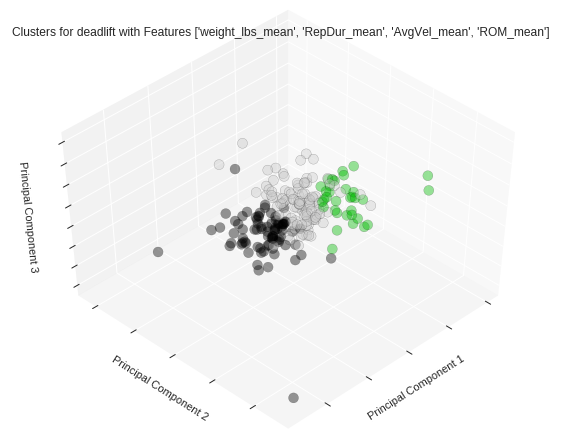

In [333]:
Z, max_d, clusters = make_clusters(df_deadlift_train, 0.5, verbose=VERBOSE)
df_deadlift_cluster = df_deadlift_train.set_index(['userID', 'exercise_clean']).join(clusters.set_index(['userID', 'exercise_clean']))
df_deadlift_cluster.reset_index(inplace=True)
# validate that clusters match make_cluster output
check_frequency(df_deadlift_cluster["Cluster"])
plot_dendogram(Z, max_d)
visualize_clusters(df_deadlift_train, final_features, clusters['Cluster'], title='Clusters for {0} with Features {1}'.format('deadlift', final_features))

## 7.5 Combining Clusters

In [386]:
# df_train_hc = df_train[~df_train['userID'].isin(outlier_ids)]
users = pd.DataFrame(df_train['userID'].unique(), columns = ['userID'])
users = (users.merge(df_bench_cluster[group_cols+['Cluster']], on='userID', how='left')
             .merge(df_squat_cluster[group_cols+['Cluster']], on='userID', how='left')
             .merge(df_deadlift_cluster[group_cols+['Cluster']], on='userID', how='left'))
users.drop(['exercise_clean_x', 'exercise_clean_y', 'exercise_clean'], 
           axis = 1, inplace=True)
users.columns = ['userID', 'Cluster_bench', 'Cluster_squat', 'Cluster_deadlift']
users.fillna(0, inplace=True)
# excluding clusters with outliers
# users = users[~users['userID'].isin(outlier_ids)]
users.head(5)

,userID,Cluster_bench,Cluster_squat,Cluster_deadlift
0,59b9b56d85ea1c6b42e4b22f,4.0,0.0,1.0
1,5a7bba5c880e87b3f32ddf40,1.0,1.0,3.0
2,5a67f20a880e87b3f32ddf21,3.0,0.0,0.0
3,58d8b1c76ca711fcd8cb7b57,4.0,0.0,3.0
4,59b96e3c85ea1c6b42e4b22c,4.0,1.0,3.0


In [0]:
df_train_with_clusters = df_train.merge(users, on='userID', how='left')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


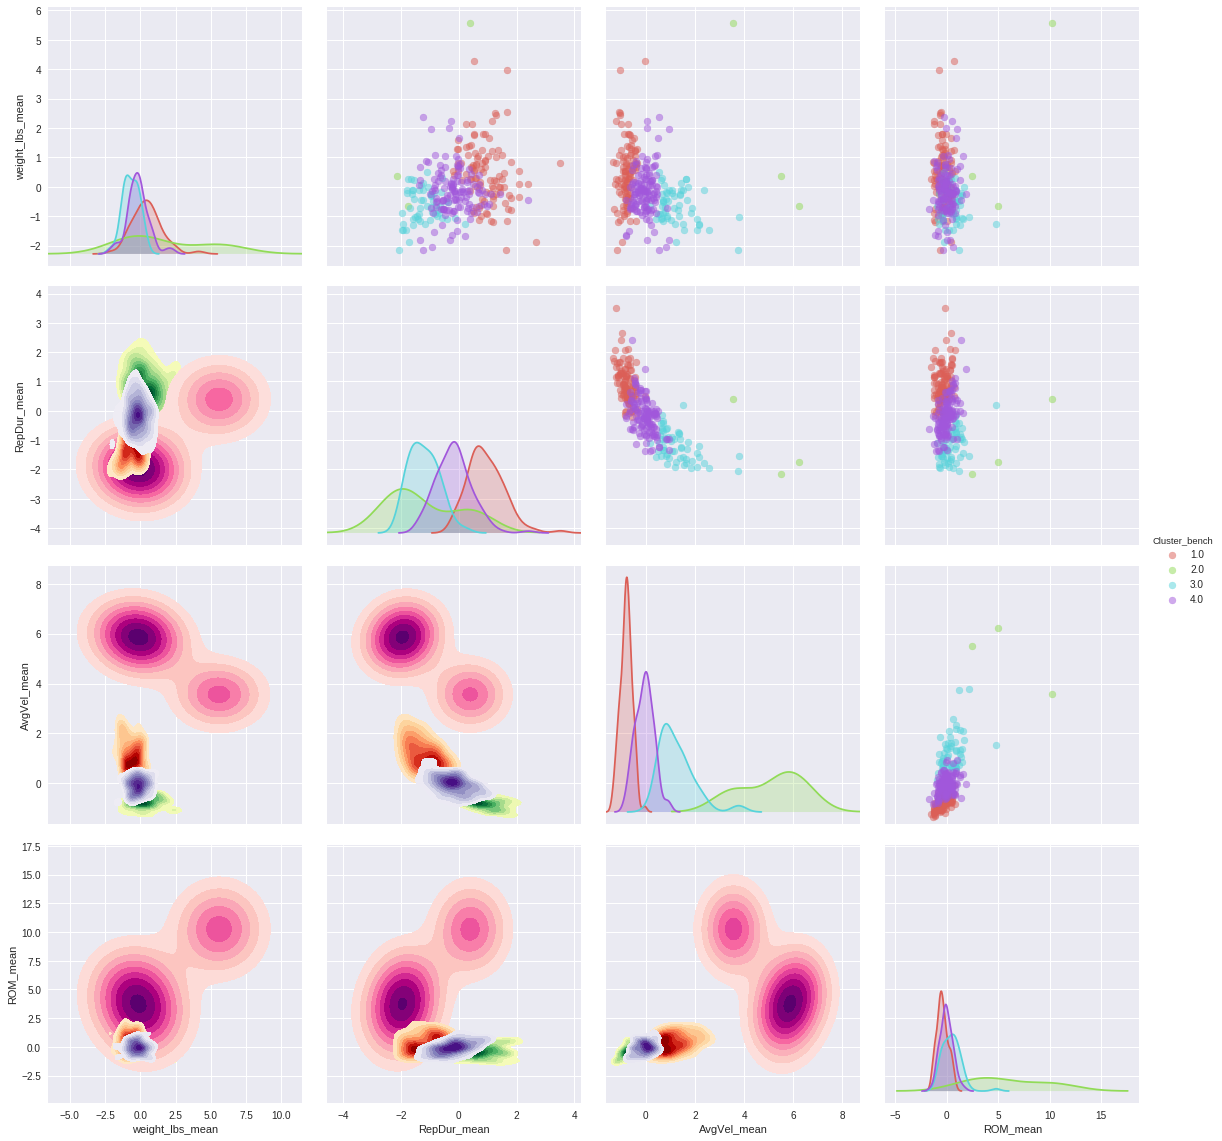

In [375]:
plot_exercise_grid(df_train_with_clusters[df_train_with_clusters['exercise_clean']=='bench'], final_features, 'Cluster_bench')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


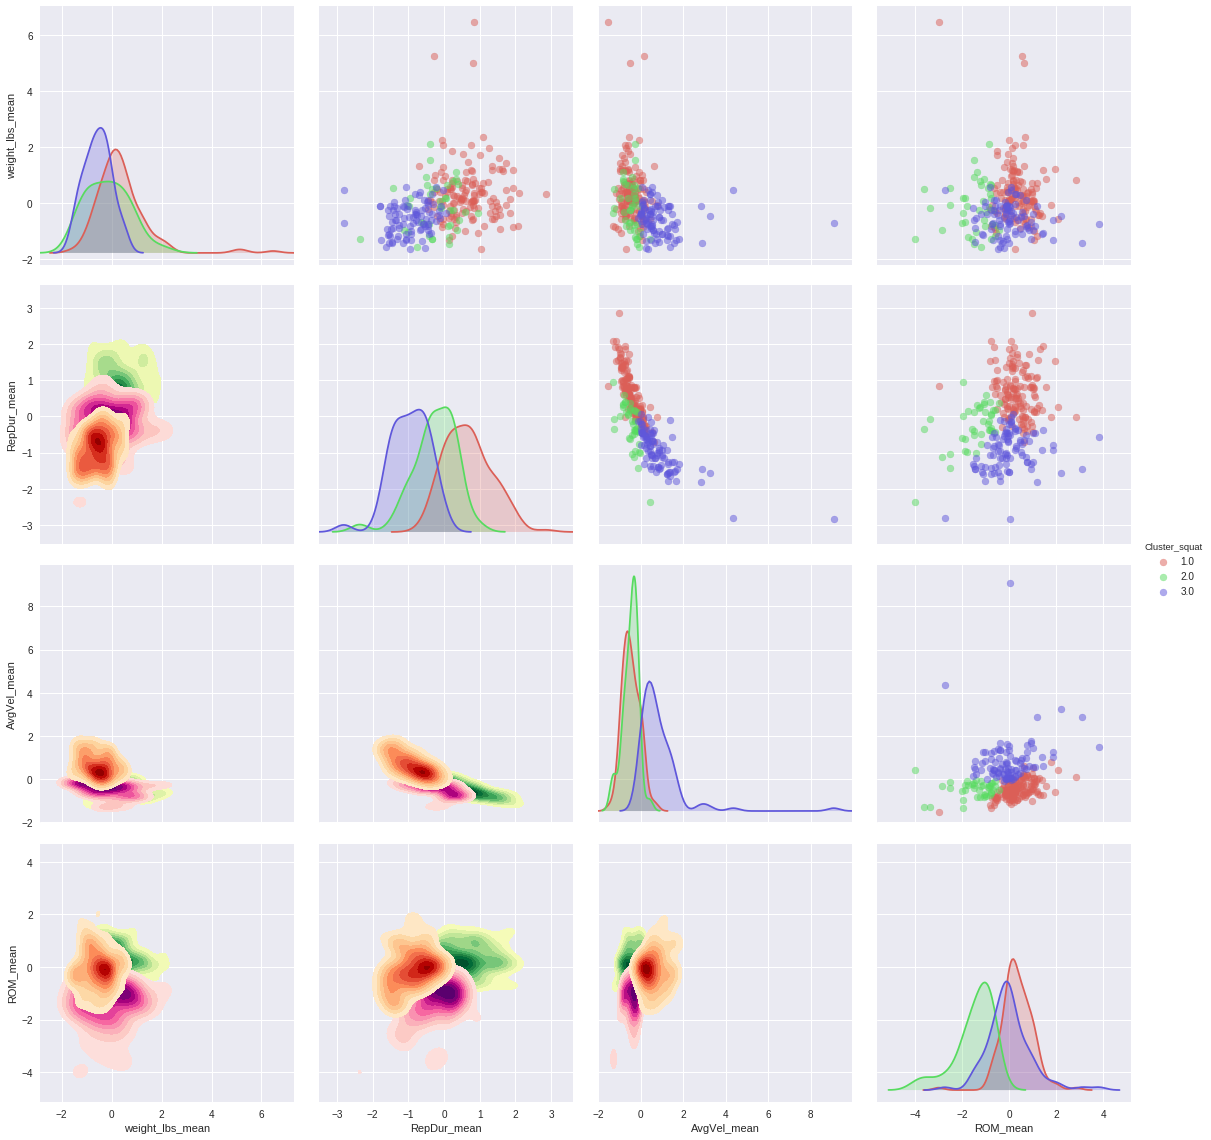

In [363]:
plot_exercise_grid(df_train_with_clusters[df_train_with_clusters['exercise_clean']=='squat'], final_features, 'Cluster_squat')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


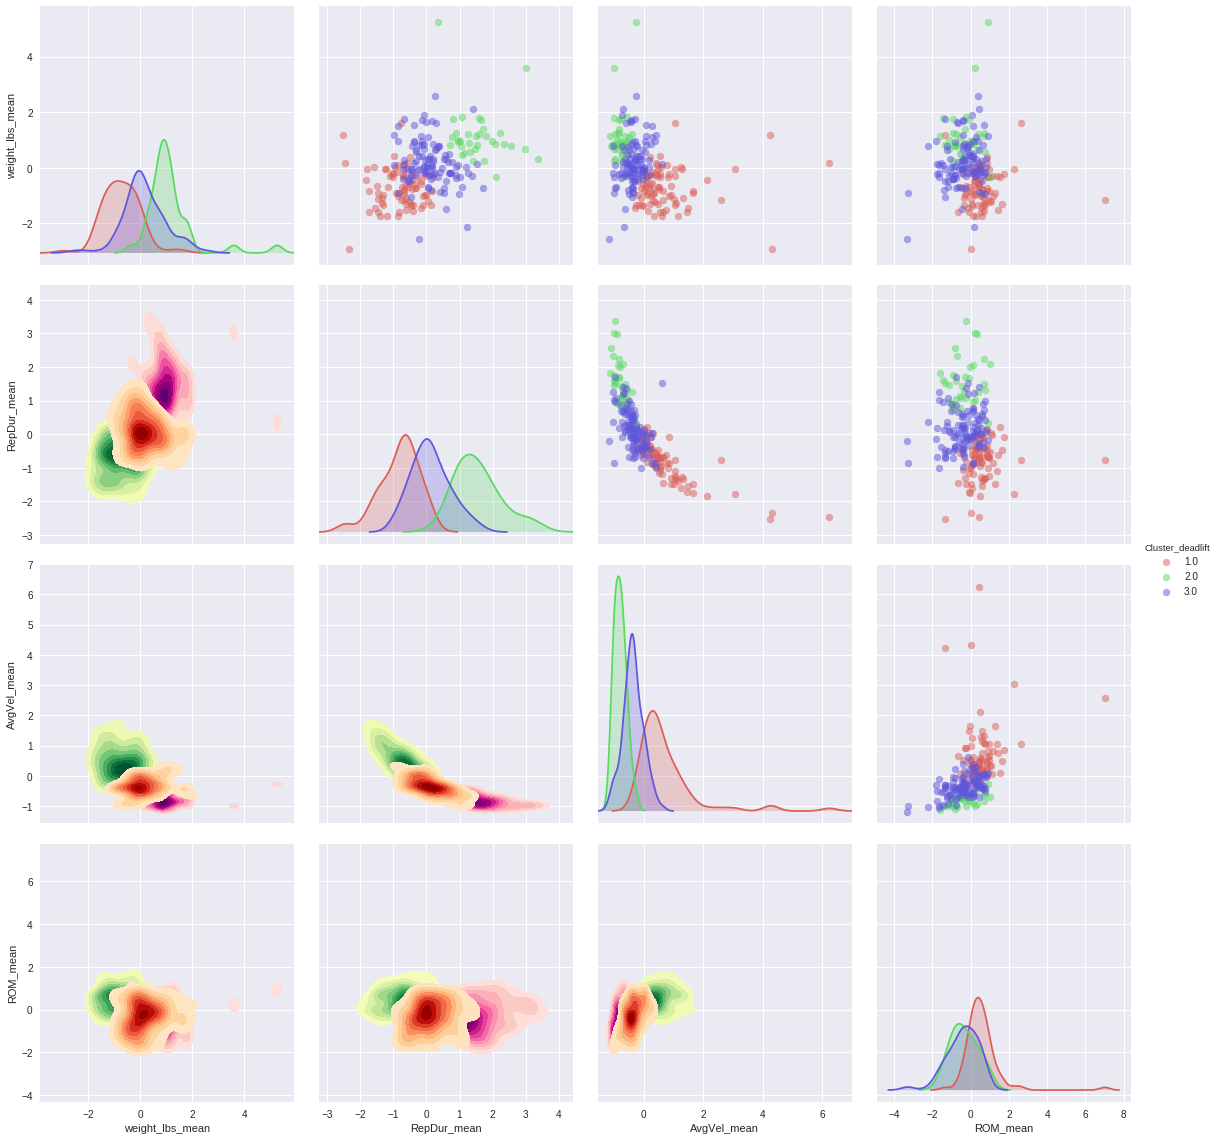

In [364]:
plot_exercise_grid(df_train_with_clusters[df_train_with_clusters['exercise_clean']=='deadlift'], final_features, 'Cluster_deadlift')

In [388]:
pd.crosstab(users['Cluster_bench'], [users['Cluster_squat'] , users['Cluster_deadlift']], 
            margins=True, dropna=False)

Cluster_squat    0.0             1.0             2.0             3.0          \
Cluster_deadlift 0.0 1.0 2.0 3.0 0.0 1.0 2.0 3.0 0.0 1.0 2.0 3.0 0.0 1.0 2.0   
Cluster_bench                                                                  
0.0                0  16   2  10  22   0   4   4   8   1   1   0  29   7   0   
1.0               17   1   5   5  16   5  16  26   2   0   4   4   3   0   0   
2.0                2   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
3.0               10   8   0   0   4   1   0   1   2   1   0   0  14  11   0   
4.0               23   6   1  10  11  11   1  21   4   2   0  12   5  11   0   
All               52  31   8  25  54  17  21  52  16   4   5  16  51  29   0   

Cluster_squat         All  
Cluster_deadlift 3.0       
Cluster_bench              
0.0                1  105  
1.0                0  104  
2.0                0    3  
3.0                5   57  
4.0                8  126  
All               14  395

# 8. Bringing It All Together

In [0]:
#@title Select Groupby Columns
userID = True  #@param {type:"boolean"}
exercise_clean = True  #@param {type:"boolean"}
workoutID = False  #@param {type:"boolean"}

# Form - Groups
group_cols = list()
if userID:
    group_cols.append('userID')
if exercise_clean:
    group_cols.append('exercise_clean')
if workoutID:
    group_cols.append('workoutID')

In [0]:
#@title Select Exercise
exercise = "bench" #@param ["squat", "bench", "deadlift"]

In [0]:
#@title Select Feature Columns
rpe_num = False  #@param {type:"boolean"}
weight_lbs = True  #@param {type:"boolean"}
RepCount = False  #@param {type:"boolean"}
ROM = True  #@param {type:"boolean"}
AvgVel = True  #@param {type:"boolean"}
PeakVel = True  #@param {type:"boolean"}
PeakVelLoc = True  #@param {type:"boolean"}
RepDur = True  #@param {type:"boolean"}
PeakAccel = False  #@param {type:"boolean"}

# Form - Features
feature_cols = list()
if rpe_num:
    feature_cols.append('rpe_num')
if weight_lbs:
    feature_cols.append('weight_lbs')
if RepCount:
    feature_cols.append('RepCount')
if ROM:
    feature_cols.append('ROM')
if AvgVel:
    feature_cols.append('AvgVel')
if PeakVel:
    feature_cols.append('PeakVel')
if PeakVelLoc:
    feature_cols.append('PeakVelLoc')
if RepDur:
    feature_cols.append('RepDur')
if PeakAccel:
    feature_cols.append('PeakAccel')

In [0]:
#@title Select Feature Aggregators
np_mean = True  #@param {type:"boolean"}
np_min = False  #@param {type:"boolean"}
np_max = False  #@param {type:"boolean"}
np_std = False  #@param {type:"boolean"}

# Form - Aggs
aggregator_funcs = list()
if np_mean:
  aggregator_funcs.append(np.mean)
if np_min:
  aggregator_funcs.append(np.min)
if np_max:
  aggregator_funcs.append(np.max)
if np_std:
  aggregator_funcs.append(np.std)

In [0]:
#@title Hierarchical Clustering Setup

cutoff = 0.45  #@param {type:"slider", min:0, max:1, step:0.01}
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
linkage_algo = 'ward'  #@param ["ward", "single", "complete", "average", "weighted", "centroid"]
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html
distance_algo = 'euclidean'  #@param ["ward", "minkowski", "cityblock", "euclidean", "seuclidean", "sqeuclidean", "cosine", "correlation", "hamming"]

In [0]:
def lifter_segmentation(data, exercise, group_cols, feature_cols, aggregator_funcs, cutoff, linkage_algo, distance_algo, dendo=False, verbose=False):
    df_exercise = select_exercise(data, exercise, verbose=verbose)
    print()
    df_grouped, final_features = group_and_aggregate_data(df_exercise, group_cols, feature_cols, aggregator_funcs, verbose=verbose)
    print()
    df_imputed = impute_data(df_grouped, verbose=verbose)
    print()
    df_clean, _ = standardize_data(df_imputed, verbose=VERBOSE)
    print()
    df_train, df_test = train_test_split(df_clean, test_size=0.1, shuffle=True, random_state=5)
    print()
    Z, max_d, clusters = make_clusters(df_train, cutoff, link=linkage_algo, dist=distance_algo, verbose=VERBOSE)
    print()
    if dendo:
        plot_dendogram(Z, max_d)
    print()
    visualize_clusters(df_train, final_features, clusters['Cluster'], title="Clusters for {0} with Features {1}".format(exercise, final_features))

    return df_train, df_test, clusters

Selected Exercise "bench": shape_before=(292910, 45), shape_after=(94640, 45)

Aggregated Data: shape=(323, 6)
Features=['weight_lbs_mean', 'ROM_mean', 'AvgVel_mean', 'PeakVel_mean', 'PeakVelLoc_mean', 'RepDur_mean']
Grouped and Aggregated Data: shape=(323, 8)


Feature means before impute:
 weight_lbs_mean       201.73
ROM_mean              343.09
AvgVel_mean             0.46
PeakVel_mean            0.67
PeakVelLoc_mean        62.82
RepDur_mean        925525.93
dtype: float64

Number of missing values: 17

Feature means after impute:
 weight_lbs_mean       201.54
ROM_mean              343.09
AvgVel_mean             0.46
PeakVel_mean            0.67
PeakVelLoc_mean        62.87
RepDur_mean        925443.57
dtype: float64

Number of missing after impute:
 weight_lbs_mean    0
ROM_mean           0
AvgVel_mean        0
PeakVel_mean       0
PeakVelLoc_mean    0
RepDur_mean        0
dtype: int64


Means of standardized features:
 weight_lbs_mean   -0.0
ROM_mean          -0.0
AvgVel_mean    

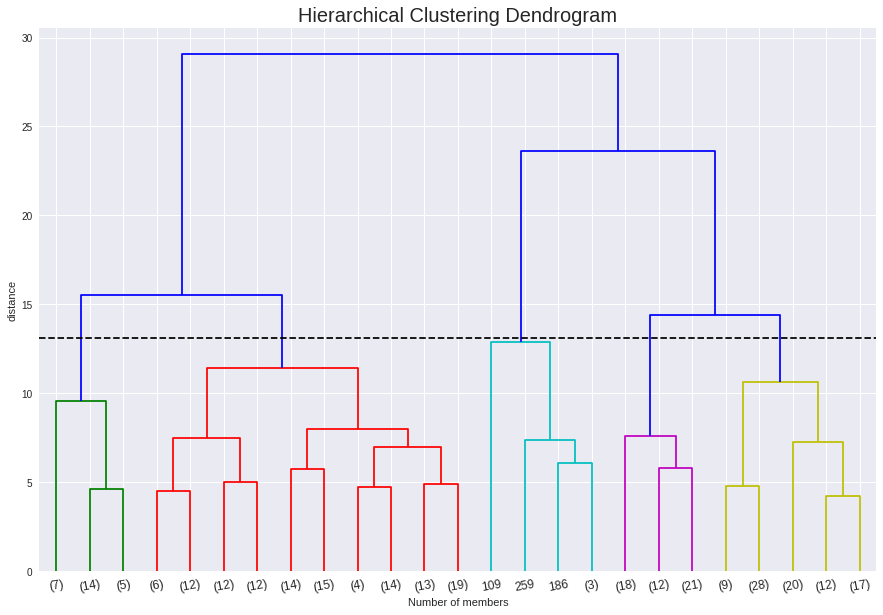


['weight_lbs_mean', 'ROM_mean', 'AvgVel_mean', 'PeakVel_mean', 'PeakVelLoc_mean', 'RepDur_mean']
Dimensions > 3. Running PCA with n=3.


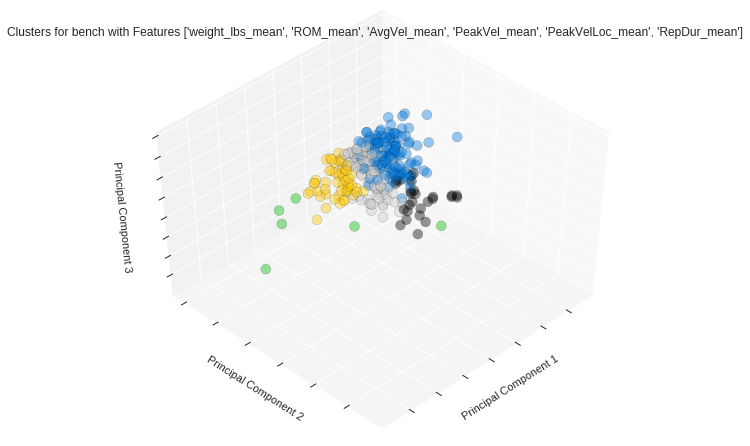

In [383]:
_, _, _ = lifter_segmentation(df, exercise, group_cols, feature_cols, aggregator_funcs, cutoff, linkage_algo, distance_algo, dendo=True, verbose=VERBOSE)

# 9. Example User

Now that we have our clusters, we can demonstrate how our users will benefit. Here, we fit a simple K Nearest Neighbors classifier to our now labeled data. We then select a random user from the dataset and use the trained KNN model to identify which cluster they belong to. From there, we present the user with useful information about other lifters in their cluster that they can compare themselves to.

In [0]:
KnnClsf = KNeighborsClassifier(len(np.unique(clusters)))
KnnClsf = KnnClsf.fit(df_train, clusters)
#accuracy = KnnClsf.score(df_test, clusters_test)
#print(accuracy)

In [107]:
df_users, _ = group_and_aggregate_data(df, ['userID'], feature_cols, aggregator_funcs, verbose=False)
example_user = pd.DataFrame(df_users.iloc[100]).T

print('The Example User:\n')
print(example_user)

user_cluster = KnnClsf.predict(example_user)[0]

print('\nPredicted Cluster =\n\n{0}'.format(user_cluster))

print('\nUseful info about Cluster {0}:\n'.format(user_cluster))

df_cluster = df_train.copy(deep=True)
df_cluster['cluster'] = clusters
df_cluster = df_cluster[df_cluster['cluster'] == 5]

#print('Weight (lbs) Max:  {0}'.format(scaler.inverse_transform(df_train['weight_lbs_mean'].max())))
print('Weight (lbs) Max:  {0}'.format(df_train['weight_lbs_mean'].max()))
print('             Min:  {0}'.format(df_train['weight_lbs_mean'].min()))
print('             Mean: {0}'.format(df_train['weight_lbs_mean'].mean()))
print('Avg Velocity Max:  {0}'.format(df_train['AvgVel_mean'].max()))
print('             Min:  {0}'.format(df_train['AvgVel_mean'].min()))
print('             Mean: {0}'.format(df_train['AvgVel_mean'].mean()))

# todo - reverse scaling or start anew


The Example User:

     weight_lbs_mean    ROM_mean  AvgVel_mean   RepDur_mean
100            185.0  626.416667     0.514888  1.219762e+06

Predicted Cluster =

4

Useful info about Cluster 4:

Weight (lbs) Max:  4.634509983950425
             Min:  -1.6934072362408708
             Mean: 0.06607638186225061
Avg Velocity Max:  5.762889952043641
             Min:  -1.0225478742243563
             Mean: 0.1756018910079055


In [0]:
!kill -9 -1